<a href="https://colab.research.google.com/github/Basu8971/Materraproject/blob/main/Model-Heatunits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Index(['FarmerName', 'Quarter 1', 'Quarter 2', 'Quarter 3', 'Yield',
       'HeatUnit1', 'HeatUnit2', 'HeatUnit3'],
      dtype='object')
                    FarmerName Quarter 1 Quarter 2 Quarter 3 Yield HeatUnit1  \
0      Ajaybhai Manubhai Patel  813.4611  662.4042  648.6617   493  813.4611   
1   Ajaysinh Himmatsinh Rathod  800.4892  831.0763  583.3064   223  800.4892   
2  Ajitbhai Narsangbhai Parmar  512.0864  538.1066  516.5054    60  512.0864   
3     Ajitsinh Mansinh Chavada  930.7215  800.7183  638.1829   342  930.7215   
4     Ajitsinh Rajusinh Bihola  797.9806  643.0804  631.3911   379  797.9806   

   HeatUnit2  HeatUnit3  
0  1475.8653   2124.527  
1  1631.5655  2214.8719  
2   1050.193  1566.6984  
3  1731.4398  2369.6227  
4   1441.061  2072.4521  
All required columns are present!
Regression Equation for HeatUnit1:
Yield = 112.2892 + (0.5334) * HeatUnit1


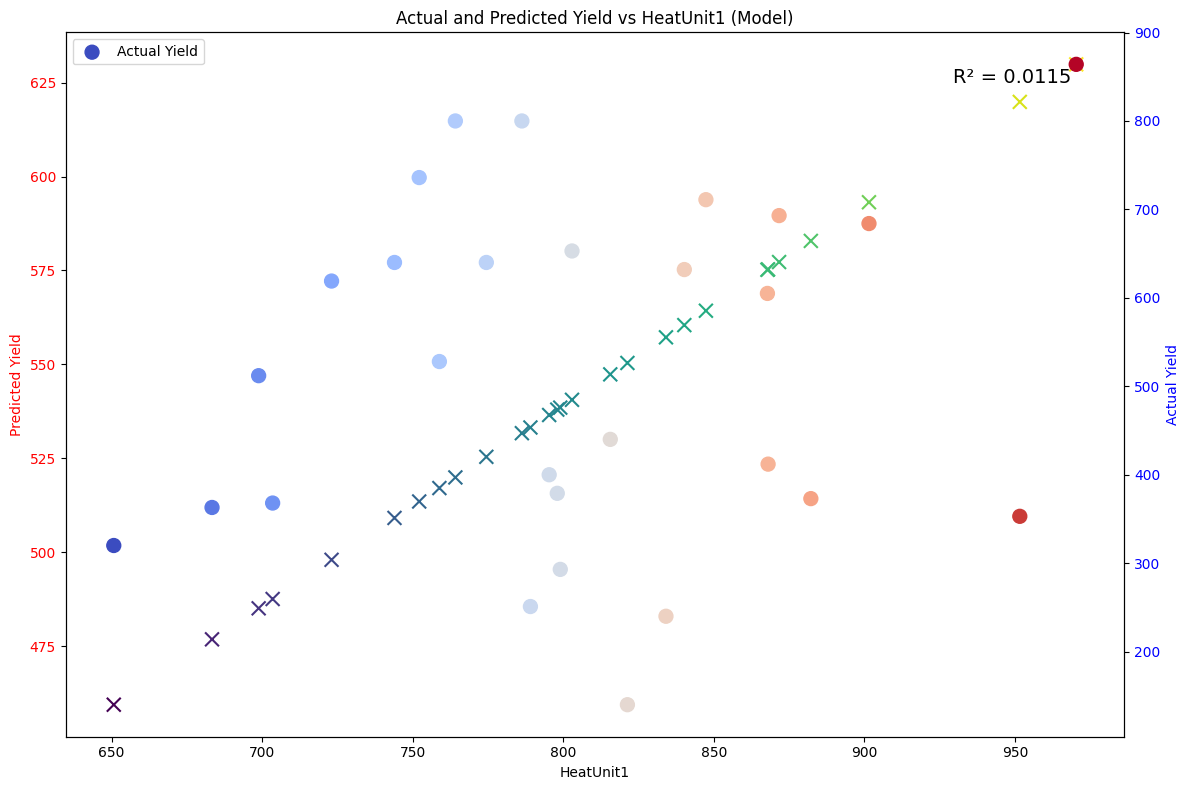

R-squared (Validation, HeatUnit1): 0.011520195609451944
Regression Equation for HeatUnit2:
Yield = 227.7421 + (0.2071) * HeatUnit2


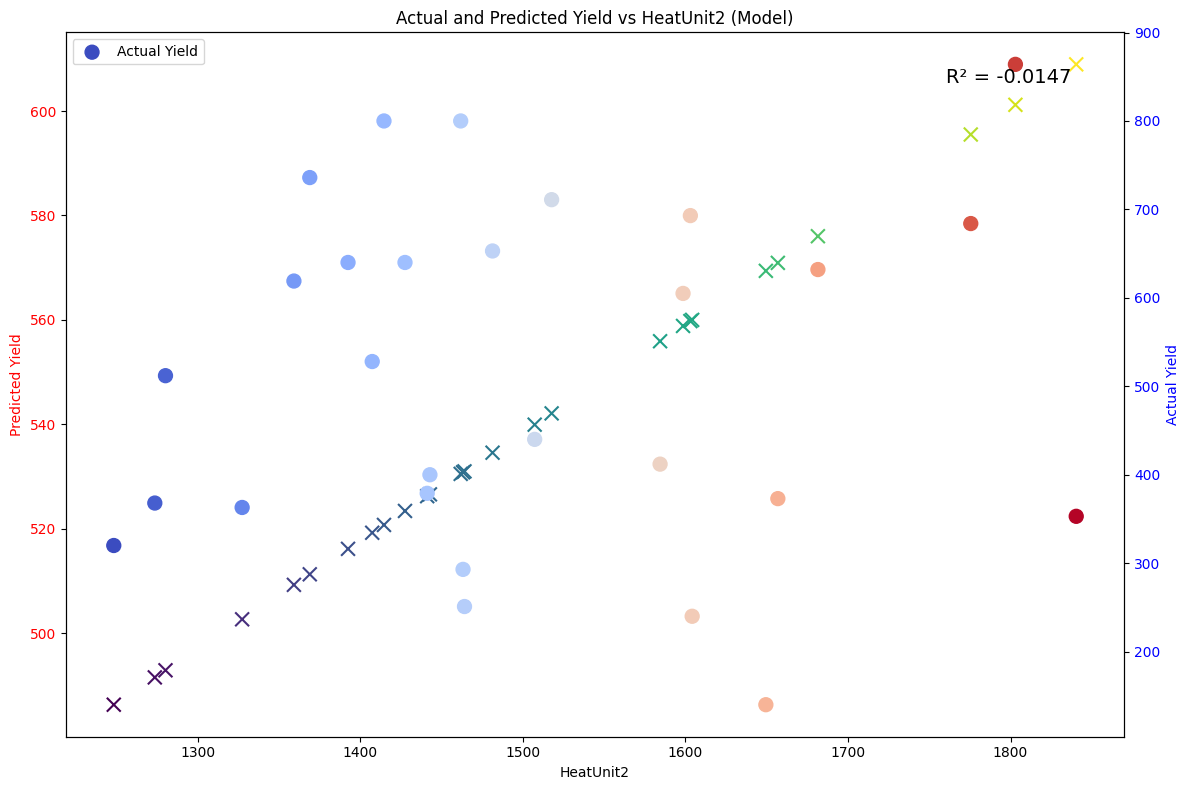

R-squared (Validation, HeatUnit2): -0.014689705624079563
Regression Equation for HeatUnit3:
Yield = 16.9382 + (0.2478) * HeatUnit3


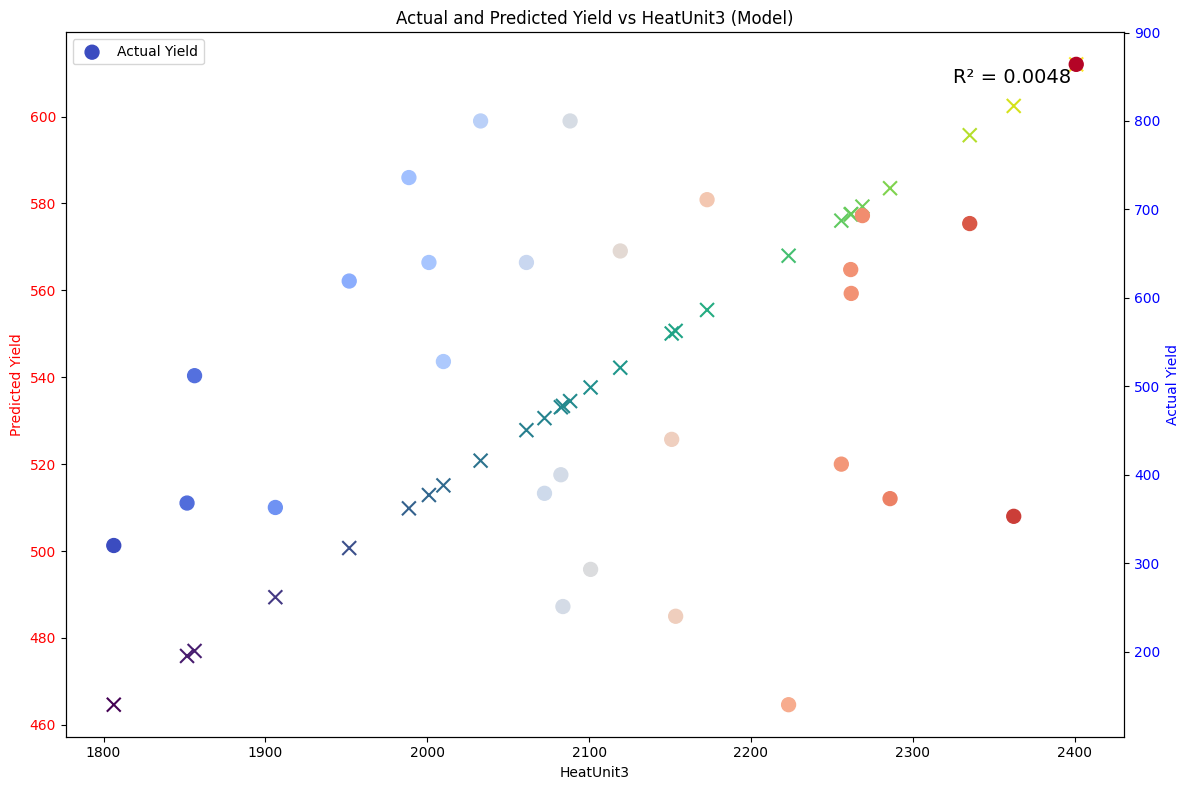

R-squared (Validation, HeatUnit3): 0.004817711373537925


In [15]:
# Install necessary libraries (if not already installed)
!pip install --upgrade gspread google-auth statsmodels scikit-learn matplotlib

# Authenticate and access Google Sheets
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Authenticate and authorize access to Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Access the heat unit data from Google Sheets
quarter_data_url = 'https://docs.google.com/spreadsheets/d/178pxG7k78BFjucPKfCEWA0ulBZ45vJuyMRLG-MA7KFw/edit?gid=375581760#gid=375581760'

# Open the sheet using gspread
quarter_data_sheet = gc.open_by_url(quarter_data_url)

# Fetch all data from the sheet
quarter_data_raw = quarter_data_sheet.sheet1.get_all_values()

# Convert the data to a pandas DataFrame
quarter_data_df = pd.DataFrame(quarter_data_raw[1:], columns=quarter_data_raw[0])

# Step 1: Inspect the column names and data types to avoid any KeyError
print(quarter_data_df.columns)  # Print column names
print(quarter_data_df.head())   # Check the first few rows of the data

# Step 2: Clean the data (convert columns to appropriate types)
quarter_data_df['HeatUnit1'] = pd.to_numeric(quarter_data_df['HeatUnit1'], errors='coerce')  # Use 'HeatUnit1'
quarter_data_df['HeatUnit2'] = pd.to_numeric(quarter_data_df['HeatUnit2'], errors='coerce')  # Use 'HeatUnit2'
quarter_data_df['HeatUnit3'] = pd.to_numeric(quarter_data_df['HeatUnit3'], errors='coerce')  # Use 'HeatUnit3'
quarter_data_df['Yield'] = pd.to_numeric(quarter_data_df['Yield'], errors='coerce')

# Step 3: Remove rows with missing values in the required columns
quarter_data_df = quarter_data_df.dropna(subset=['HeatUnit1', 'HeatUnit2', 'HeatUnit3', 'Yield'])

# Step 4: Check if all necessary columns exist for OLS modeling
required_columns = ['FarmerName', 'HeatUnit1', 'HeatUnit2', 'HeatUnit3', 'Yield']
missing_columns = [col for col in required_columns if col not in quarter_data_df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All required columns are present!")

# Step 5: Train OLS models and validate for each heat unit (1, 2, 3)
heat_units = ['HeatUnit1', 'HeatUnit2', 'HeatUnit3']
for heat_unit in heat_units:
    # Features (independent variable) and target (dependent variable)
    X = quarter_data_df[[heat_unit]]  # Select the respective heat unit column
    y = quarter_data_df['Yield']  # Yield as target

    # Step 6: Split the data into training (80%) and validation (20%) sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Add a constant to the independent variable for the intercept in OLS
    X_train = sm.add_constant(X_train)  # Adds an intercept (constant) to the model
    X_val = sm.add_constant(X_val)

    # Step 7: Fit the OLS regression model
    ols_model = sm.OLS(y_train, X_train).fit()

    # Step 8: Print the equation of the regression model
    intercept = ols_model.params['const']
    coefficient = ols_model.params[heat_unit]
    print(f"Regression Equation for {heat_unit}:")
    print(f"Yield = {intercept:.4f} + ({coefficient:.4f}) * {heat_unit}")

    # Step 9: Predict yield for the validation data
    y_val_pred = ols_model.predict(X_val)

    # Step 10: Calculate R-squared for the validation data
    r2_val = r2_score(y_val, y_val_pred)

    # Step 11: Plot Predicted Yield vs Actual Yield for the validation data (one dot per farmer)
    plt.figure(figsize=(12, 8))

    # Create the left y-axis for predicted values
    ax1 = plt.gca()

    # Plot predicted values for validation (red) - one dot per farmer
    scatter_pred = ax1.scatter(X_val[heat_unit], y_val_pred, c=X_val[heat_unit], cmap='viridis', s=100, label='Predicted Yield', marker='x')

    # Set left y-axis label for Predicted Yield
    ax1.set_xlabel(f'{heat_unit}')
    ax1.set_ylabel('Predicted Yield', color='red')
    ax1.tick_params(axis='y', labelcolor='red')

    # Create the right y-axis for actual values
    ax2 = ax1.twinx()

    # Plot actual values for validation (blue) - one dot per farmer
    scatter_actual = ax2.scatter(X_val[heat_unit], y_val, c=X_val[heat_unit], cmap='coolwarm', s=100, label='Actual Yield', marker='o')

    # Set right y-axis label for Actual Yield
    ax2.set_ylabel('Actual Yield', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    # Add title and legend
    plt.title(f'Actual and Predicted Yield vs {heat_unit} (Model)')
    plt.legend(loc='upper left')

    # Display the R-squared value on the graph for validation data in the top-right corner
    plt.text(0.95, 0.95, f'R² = {r2_val:.4f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right')

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Print the R-squared value for validation data
    print(f'R-squared (Validation, {heat_unit}): {r2_val}')


Index(['FarmerName', 'Quarter 1', 'Quarter 2', 'Quarter 3', 'Yield',
       'HeatUnit1', 'HeatUnit2', 'HeatUnit3'],
      dtype='object')
                    FarmerName Quarter 1 Quarter 2 Quarter 3 Yield HeatUnit1  \
0      Ajaybhai Manubhai Patel  813.4611  662.4042  648.6617   493  813.4611   
1   Ajaysinh Himmatsinh Rathod  800.4892  831.0763  583.3064   223  800.4892   
2  Ajitbhai Narsangbhai Parmar  512.0864  538.1066  516.5054    60  512.0864   
3     Ajitsinh Mansinh Chavada  930.7215  800.7183  638.1829   342  930.7215   
4     Ajitsinh Rajusinh Bihola  797.9806  643.0804  631.3911   379  797.9806   

   HeatUnit2  HeatUnit3  
0  1475.8653   2124.527  
1  1631.5655  2214.8719  
2   1050.193  1566.6984  
3  1731.4398  2369.6227  
4   1441.061  2072.4521  
All required columns are present!
Model 1: Quarter 1 -> Yield
                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.059
Model

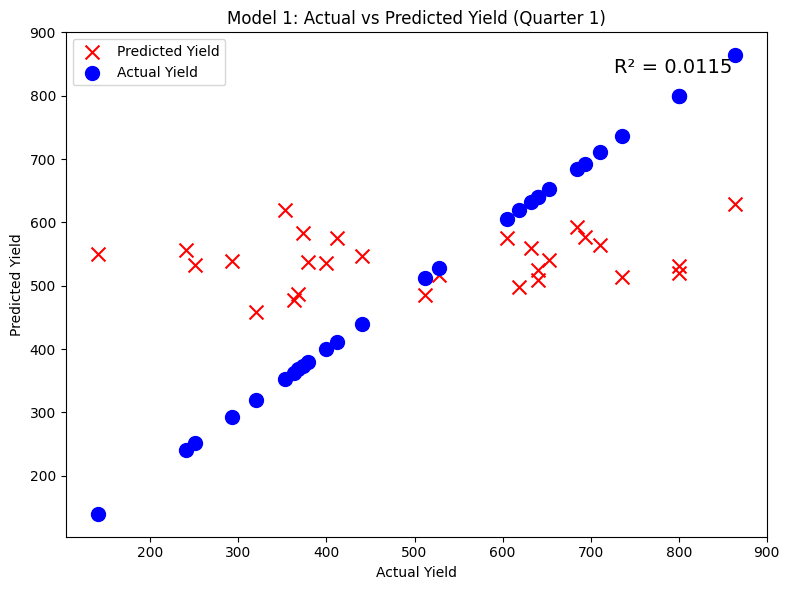


Model 2: Quarter 2 -> Yield
                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7214
Date:                Thu, 16 Jan 2025   Prob (F-statistic):              0.398
Time:                        09:07:55   Log-Likelihood:                -726.45
No. Observations:                 108   AIC:                             1457.
Df Residuals:                     106   BIC:                             1462.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        391.0255  

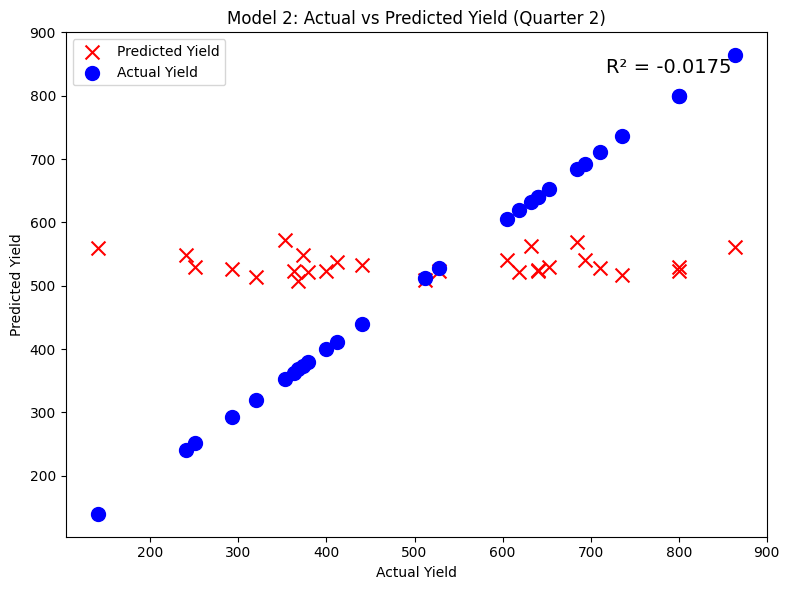


Model 3: Quarter 3 -> Yield
                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     18.84
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           3.25e-05
Time:                        09:07:55   Log-Likelihood:                -717.98
No. Observations:                 108   AIC:                             1440.
Df Residuals:                     106   BIC:                             1445.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -513.9126  

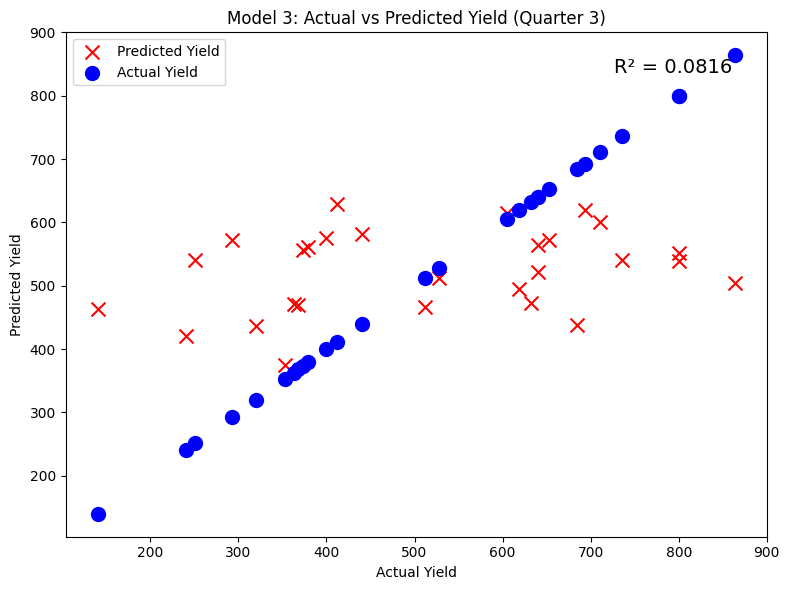

In [19]:
# Install necessary libraries (if not already installed)
!pip install --upgrade gspread google-auth statsmodels scikit-learn matplotlib

# Authenticate and access Google Sheets
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Authenticate and authorize access to Google Sheets
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# Access the heat unit data from Google Sheets
quarter_data_url = 'https://docs.google.com/spreadsheets/d/178pxG7k78BFjucPKfCEWA0ulBZ45vJuyMRLG-MA7KFw/edit?gid=375581760#gid=375581760'

# Open the sheet using gspread
quarter_data_sheet = gc.open_by_url(quarter_data_url)

# Fetch all data from the sheet
quarter_data_raw = quarter_data_sheet.sheet1.get_all_values()

# Convert the data to a pandas DataFrame
quarter_data_df = pd.DataFrame(quarter_data_raw[1:], columns=quarter_data_raw[0])

# Step 1: Inspect the column names and data types to avoid any KeyError
print(quarter_data_df.columns)  # Print column names
print(quarter_data_df.head())   # Check the first few rows of the data

# Step 2: Clean the data (convert columns to appropriate types)
quarter_data_df['Quarter 1'] = pd.to_numeric(quarter_data_df['Quarter 1'], errors='coerce')
quarter_data_df['Quarter 2'] = pd.to_numeric(quarter_data_df['Quarter 2'], errors='coerce')
quarter_data_df['Quarter 3'] = pd.to_numeric(quarter_data_df['Quarter 3'], errors='coerce')
quarter_data_df['Yield'] = pd.to_numeric(quarter_data_df['Yield'], errors='coerce')

# Step 3: Remove rows with missing values in the required columns
quarter_data_df = quarter_data_df.dropna(subset=['Quarter 1', 'Quarter 2', 'Quarter 3', 'Yield'])

# Step 4: Check if all necessary columns exist for OLS modeling
required_columns = ['FarmerName', 'Quarter 1', 'Quarter 2', 'Quarter 3', 'Yield']
missing_columns = [col for col in required_columns if col not in quarter_data_df.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All required columns are present!")

# Step 5: Prepare separate models for each quarter

# Model 1: Using 'Quarter 1' to predict 'Yield'
X1 = quarter_data_df[['Quarter 1']]  # Feature (independent variable)
y1 = quarter_data_df['Yield']  # Target (dependent variable)

# Add a constant to the feature matrix (intercept term)
X1 = sm.add_constant(X1)

# Split the data into training (80%) and validation (20%) sets
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Fit the OLS model for Quarter 1
ols_model_1 = sm.OLS(y1_train, X1_train).fit()

# Predict the target variable for validation set
y1_val_pred = ols_model_1.predict(X1_val)

# Calculate R-squared for the validation data
r2_val_1 = r2_score(y1_val, y1_val_pred)

# Print summary of the model
print("Model 1: Quarter 1 -> Yield")
print(ols_model_1.summary())
print(f'R-squared (Validation, Model 1): {r2_val_1}')

# Plot Predicted Yield vs Actual Yield for Model 1
plt.figure(figsize=(8, 6))
plt.scatter(y1_val, y1_val_pred, c='red', s=100, label='Predicted Yield', marker='x')
plt.scatter(y1_val, y1_val, c='blue', s=100, label='Actual Yield', marker='o')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Model 1: Actual vs Predicted Yield (Quarter 1)')
plt.legend(loc='upper left')
plt.text(0.95, 0.95, f'R² = {r2_val_1:.4f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right')
plt.tight_layout()
plt.show()

# Model 2: Using 'Quarter 2' to predict 'Yield'
X2 = quarter_data_df[['Quarter 2']]  # Feature (independent variable)
y2 = quarter_data_df['Yield']  # Target (dependent variable)

# Add a constant to the feature matrix (intercept term)
X2 = sm.add_constant(X2)

# Split the data into training (80%) and validation (20%) sets
X2_train, X2_val, y2_train, y2_val = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Fit the OLS model for Quarter 2
ols_model_2 = sm.OLS(y2_train, X2_train).fit()

# Predict the target variable for validation set
y2_val_pred = ols_model_2.predict(X2_val)

# Calculate R-squared for the validation data
r2_val_2 = r2_score(y2_val, y2_val_pred)

# Print summary of the model
print("\nModel 2: Quarter 2 -> Yield")
print(ols_model_2.summary())
print(f'R-squared (Validation, Model 2): {r2_val_2}')

# Plot Predicted Yield vs Actual Yield for Model 2
plt.figure(figsize=(8, 6))
plt.scatter(y2_val, y2_val_pred, c='red', s=100, label='Predicted Yield', marker='x')
plt.scatter(y2_val, y2_val, c='blue', s=100, label='Actual Yield', marker='o')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Model 2: Actual vs Predicted Yield (Quarter 2)')
plt.legend(loc='upper left')
plt.text(0.95, 0.95, f'R² = {r2_val_2:.4f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right')
plt.tight_layout()
plt.show()

# Model 3: Using 'Quarter 3' to predict 'Yield'
X3 = quarter_data_df[['Quarter 3']]  # Feature (independent variable)
y3 = quarter_data_df['Yield']  # Target (dependent variable)

# Add a constant to the feature matrix (intercept term)
X3 = sm.add_constant(X3)

# Split the data into training (80%) and validation (20%) sets
X3_train, X3_val, y3_train, y3_val = train_test_split(X3, y3, test_size=0.2, random_state=42)

# Fit the OLS model for Quarter 3
ols_model_3 = sm.OLS(y3_train, X3_train).fit()

# Predict the target variable for validation set
y3_val_pred = ols_model_3.predict(X3_val)

# Calculate R-squared for the validation data
r2_val_3 = r2_score(y3_val, y3_val_pred)

# Print summary of the model
print("\nModel 3: Quarter 3 -> Yield")
print(ols_model_3.summary())
print(f'R-squared (Validation, Model 3): {r2_val_3}')

# Plot Predicted Yield vs Actual Yield for Model 3
plt.figure(figsize=(8, 6))
plt.scatter(y3_val, y3_val_pred, c='red', s=100, label='Predicted Yield', marker='x')
plt.scatter(y3_val, y3_val, c='blue', s=100, label='Actual Yield', marker='o')
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Model 3: Actual vs Predicted Yield (Quarter 3)')
plt.legend(loc='upper left')
plt.text(0.95, 0.95, f'R² = {r2_val_3:.4f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', horizontalalignment='right')
plt.tight_layout()
plt.show()
